<a href="https://colab.research.google.com/github/iciromaco/Semi3A/blob/master/L8/CardCapture1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![代替テキスト](http://jr-miyajimaferry.co.jp/wp-content/themes/jr-miyajimaferry.co.jp/ic_card/images/ic2_icoca@2x.png)

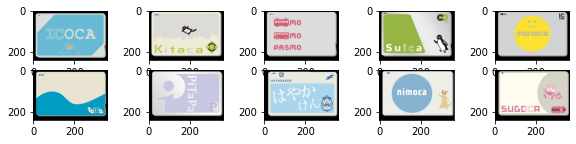

In [1]:
import urllib.request
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

cards = ["ic2_icoca@2x","ic3_kitaca@2x","ic4_pasmo@2x","ic5_suica@2x","ic6_manaca@2x",
"ic7_toica@2x","ic8_pitapa@2x","ic9_hayakaken@2x","ic10_nimoca@2x","ic11_sugoca@2x"]

urlhead = "http://jr-miyajimaferry.co.jp/wp-content/themes/jr-miyajimaferry.co.jp/ic_card/images/"

cimgs = []
plt.figure(figsize=(10,2))
for i,card in enumerate(cards):
  img_path, header = urllib.request.urlretrieve(urlhead+card+".png")
  img = cv2.imread(img_path,1)
  cimgs.append(img[:240,:])
  plt.subplot(2,5,i+1)
  plt.imshow(cimgs[i][:,:,::-1])
  

In [2]:
cv2.AKAZE_create(threshold=1)

<AKAZE 0x7f9bd7746ef0>

In [3]:

# AKAZE特徴検出器 https://docs.opencv.org/master/d8/d30/classcv_1_1AKAZE.html
akaze = cv2.AKAZE_create(threshold = 0.0001) # default: 0.001
# ORB特徴検出器
orb = cv2.ORB_create() # 50点を上限とする 
ncards = len(cards)

# カードのクラス定義
class card:
    def __init__(self,img):
        self.col = img
        self.gry = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        #self.gry = cv2.GaussianBlur(img,(13,13),0)        # ガウスフィルタでぼかす
        # 画像のサイズ
        self.h,self.w,_ = self.col.shape
        (self.kps, self.des) = akaze.detectAndCompute(self.gry,None)
        #(self.kps, self.des) = orb.detectAndCompute(self.gry,None)
        print("特徴数 {}".format(len(self.kps)))

cardDB = [None]*ncards
for i,img in enumerate(cimgs):
  cardDB[i] = thecard = card(img) # カードの登録

特徴数 221
特徴数 149
特徴数 228
特徴数 165
特徴数 132
特徴数 115
特徴数 130
特徴数 325
特徴数 185
特徴数 226


# AKAZE特徴の例


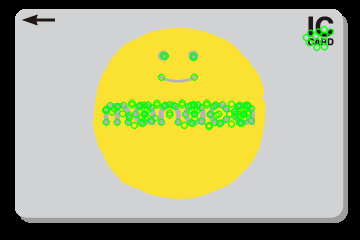

In [4]:

img = cardDB[4].col
kps = cardDB[4].kps
outimg = cv2.drawKeypoints(img,kps,None,color=(0,255,0), flags=0)
cv2_imshow(outimg)

# Keypoints

In [5]:
len(kps) # 特徴数

132

In [6]:
kps[0].pt # 特徴の座標

(323.7004089355469, 29.03907585144043)

In [7]:
kps[0].size # サイズ

4.800000190734863

In [8]:
kps[0].angle # 基準方向の角度

339.2476806640625

# Description

In [9]:
desc1 = cardDB[4].des
desc1,len(desc1[0])

(array([[  3,  28, 244, ..., 233, 255,  56],
        [ 62,   2, 244, ...,  94,   0,  33],
        [  3, 252, 132, ..., 248, 255,   1],
        ...,
        [128,   7,  54, ..., 255, 207,  30],
        [167,  31, 224, ..., 249, 255,  15],
        [  0,  22, 114, ..., 253, 255,  63]], dtype=uint8), 61)

# BFMatching （総当たり法）

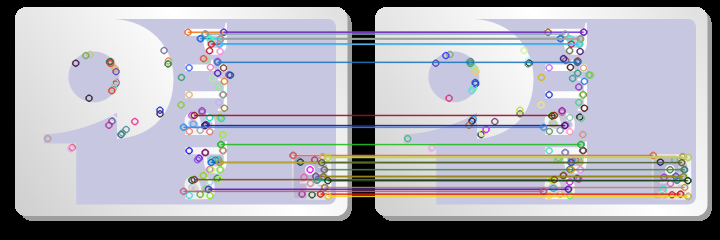

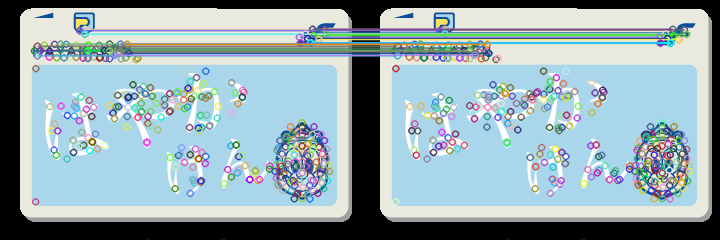

In [10]:
#bf = cv2.BFMatcher(cv2.NORM_HAMMING) # ORBの場合
bf = cv2.BFMatcher()
def showmatch(i,j):
  img = cardDB[i].col
  kps = cardDB[i].kps
  des = cardDB[i].des
  img2 = cardDB[j].col
  kps2 = cardDB[j].kps
  des2 = cardDB[j].des
  matches = bf.match(des, des2)
  img3 = cv2.drawMatches(img, kps, img2, kps2, matches[:30], None)
  cv2_imshow(img3)

showmatch(6,6)
showmatch(7,7)


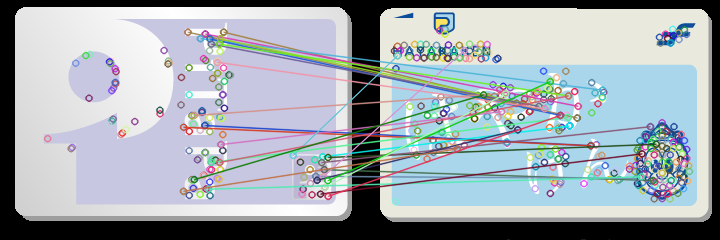

In [11]:
showmatch(6,7)

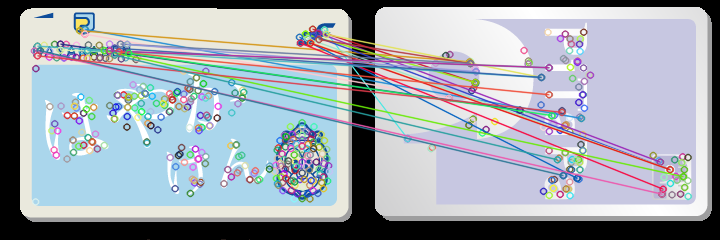

In [12]:
showmatch(7,6)

全然違う絵でも、それぞれの特徴に一番近い特徴というのは必ずあるので、どこかにマッチする。


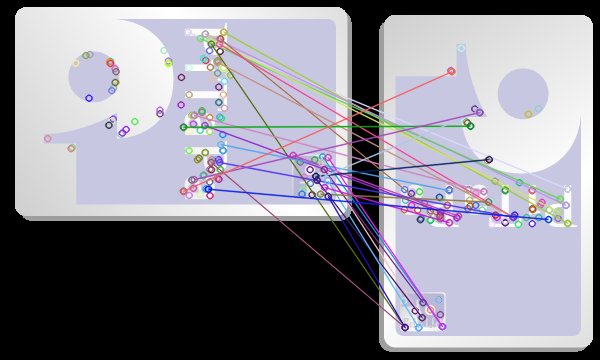

In [13]:
img=cardDB[6].col
kps = cardDB[6].kps
des = cardDB[6].des
imgT = img.transpose(1,0,2)[:,::-1]
gryT = cv2.GaussianBlur(imgT,(13,13),0)        # ガウスフィルタでぼかす
#(kpsT, desT) = orb.detectAndCompute(gryT,None)
(kpsT, desT) = akaze.detectAndCompute(gryT,None)
matches = bf.match(des, desT)
img3 = cv2.drawMatches(img, kps, imgT, kpsT, matches[:30], None) # 30点だけ結ぶ
cv2_imshow(img3)

# ANN近似最近傍探索＋K-nn
NN（近傍探索）は、近傍から順にサーチすること。しかし、多次元なので厳密な意味で近い順にサーチするのは無理である。それができるなら、探索する必要がない。

ANNは近似近傍探索。たとえば、全部の軸ではなく、いくつかの軸を選んでハッシュして並べたり、近い順に検索ツリーを形成しておく。

K-nnは、最も近い１つではなく、近い順にK個選びだすこと

In [0]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
# ORBの場合
#FLANN_INDEX_LSH = 6
#index_params= dict(algorithm = FLANN_INDEX_LSH,
#                   table_number = 6, # 12
#                   key_size = 12,     # 20
#                   multi_probe_level = 1) #2
flann = cv2.FlannBasedMatcher(index_params,search_params)

# サーチ対象画像の自動生成

In [15]:
url = "https://d2nlrppnj7be8d.cloudfront.net/materials/0000/3070/Station001.png"
img_path, header = urllib.request.urlretrieve(url)
scene = cv2.imread(img_path,1)
scene = cv2.GaussianBlur(scene,(31,31),0) 
scene.shape

(600, 800, 3)

In [0]:
from PIL import Image
pimgs = [Image.fromarray(img[:,:,::-1]) for img in cimgs]

def mkproblem(n=-1):
  if n < 0: n = np.random.randint(1,10)
  img = pimgs[n]
  r = (3+np.random.rand())/4
  aimg = img.resize((int(img.width*r), int(img.height*r)))
  angle = 360*np.random.rand()
  aimg = np.array(aimg.rotate(angle,expand=True))[:,:,::-1]
  mask = cv2.cvtColor(aimg,cv2.COLOR_BGR2GRAY)
  ret,mask = cv2.threshold(mask,0,255,cv2.THRESH_BINARY)
  contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  mask = np.zeros_like(mask)
  cnt = contours[np.argmax([len(c) for c in contours])] 
  mask = cv2.drawContours(mask, [cnt], 0, 255, -1)
  h,w = aimg.shape[:2]
  hs,ws = scene.shape[:2]
  offx = int(np.random.rand()*(3*ws/4-w)+ws/8)
  offy = int(np.random.rand()*(3*hs/4-h)+hs/8)
  img3 = cv2.bitwise_and(scene[offy:h+offy,offx:w+offx],scene[offy:h+offy,offx:w+offx],mask= 255-mask)
  canvas = scene.copy()
  canvas[offy:h+offy,offx:w+offx] = cv2.bitwise_or(img3,aimg)
  return(canvas)

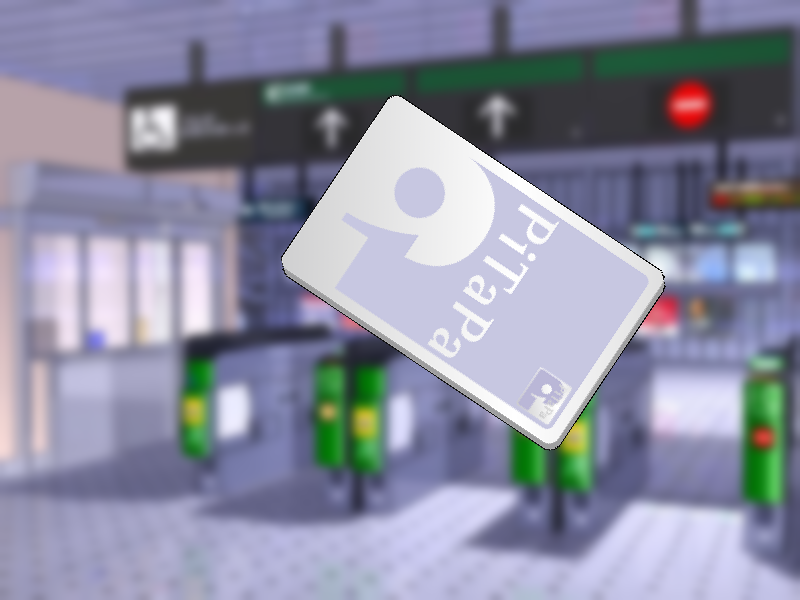

In [17]:
img = mkproblem()
cv2_imshow(img)

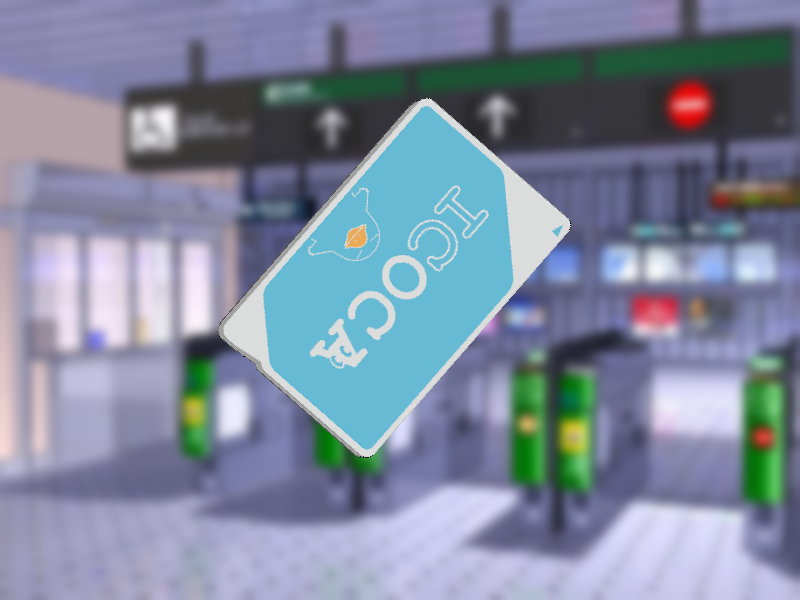

In [18]:
img = mkproblem(0)
cv2_imshow(img)

# カード番号を指定してのマッチング

In [0]:
MIN_MATCH_COUNT = 5 # これより少ない照合しかできないときは枠線を描かない。
DISTANCETHRES=1024.0 # これ以上距離がある場合は候補から外す。AKAZEは61次元 で各255までで表されている
def smatch(i,simg):
  kp1 = cardDB[i].kps
  des1 = cardDB[i].des
  des1 = np.float32(des1)
  sceneG = cv2.cvtColor(simg,cv2.COLOR_BGR2GRAY)
  (kp2, des2) = akaze.detectAndCompute(sceneG,None)
  des2 = np.float32(des2)
  matches = flann.knnMatch(des1,des2,k=2)
  good = []
  for ms in matches:
    if len(ms) == 2:
      m,n = ms
      if m.distance < DISTANCETHRES and m.distance < 0.8*n.distance: # 2番目に近いものより距離が0.9未満であるマッチングを残す
        good.append(m)
  if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0) # 変換行列
    matchesMask = mask.ravel().tolist()

    h,w = cardDB[i].gry.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(simg.copy(),[np.int32(dst)],True,255,3, cv2.LINE_AA)
    img3 = cv2.drawMatches(cardDB[i].col, cardDB[i].kps, img2, kp2, good, None)
    cv2_imshow(img3)  
  else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None
  print(matchesMask)

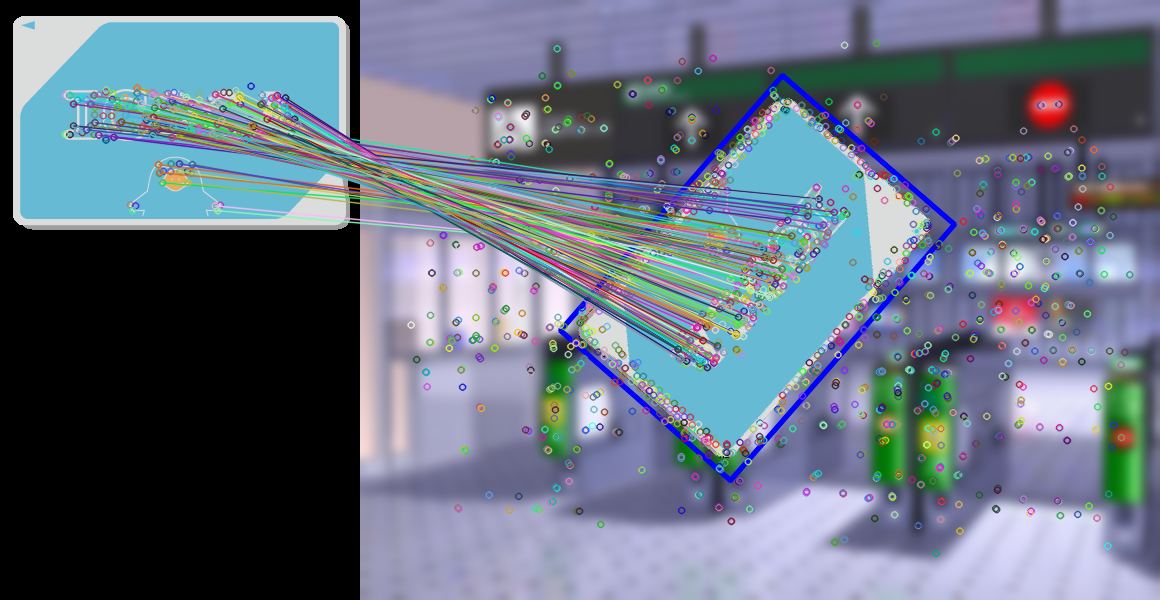

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


In [20]:
smatch(0,img)

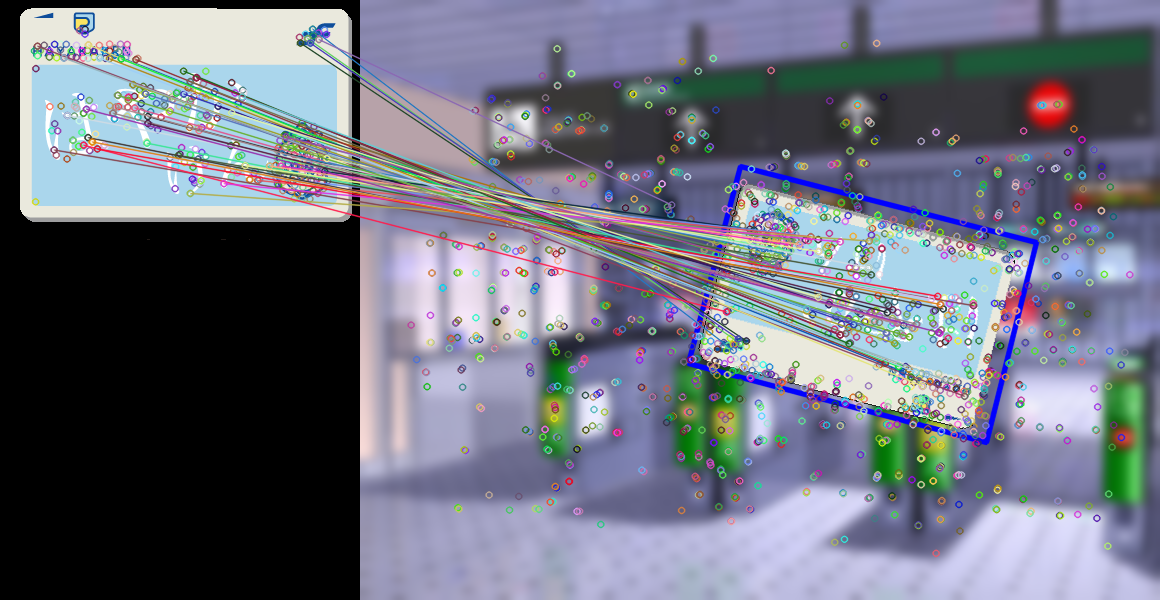

[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [21]:
img = mkproblem(7)
smatch(7,img)

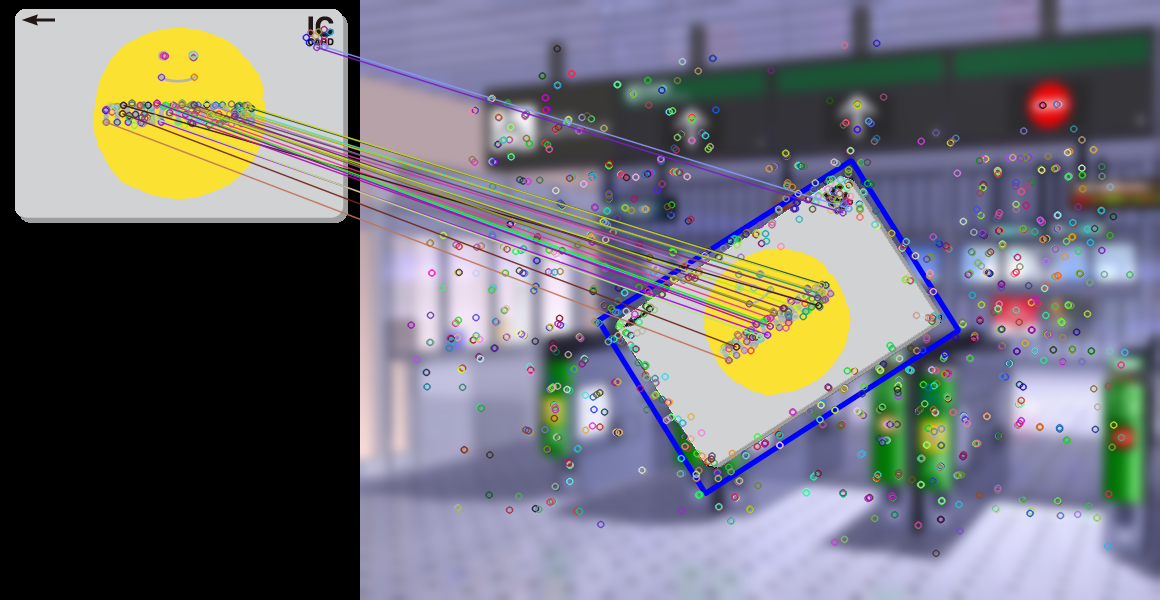

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [22]:
img = mkproblem(4)
smatch(4,img)

以上のように、あるカードが画像に写っていることが分かっていて、そのカードがどこにあるのかを見つけることはできた。


# もっともマッチするものを見つける

最後に、すべてのカードの中で最もマッチング度合いの高いカードを決定して、そのマッチングを描くことができるか試してみる

In [0]:
MIN_MATCH_COUNT = 5 # これより少ない照合しかできないときは枠線を描かない。
BIGNUMBER = 1e6 # 1000000 （大きい数値）
DISTANCETHRES=1024.0 # これ以上距離がある場合は候補から外す。AKAZEは61次元 で各255までで表されている

# 画像に対し、もっともマッチするものを応える
def bestmatch(simg):
  gray = cv2.cvtColor(simg,cv2.COLOR_BGR2GRAY)
  (kp2, des2) = akaze.detectAndCompute(gray,None)
  des2 = np.float32(des2)

  good = [None]*len(cardDB)
  for index,card in enumerate(cardDB):
    des1 = card.des
    des1 = np.float32(des1)
    kps1 = card.kps

    matches = flann.knnMatch(des1,des2,k=2)
    good[index] = []
    for ms in matches:
      if len(ms) ==  2: # 必ずしも第2候補まで見つかるとは限らない
        m,n = ms
        if m.distance < DISTANCETHRES and m.distance < 0.8*n.distance: # 2番目に近いものより距離が0.9未満であるマッチングを残す
          good[index].append(m)

  bestmatch,valmin,bestpairs = -1,BIGNUMBER,[] 
  for index in range(len(cardDB)):
    dd = np.sort([m.distance for m in good[index]])[:10] # 上位10個までのマッチング情報を取り出す
    if len(dd) > 0 and np.sum(dd)/len(dd) < valmin:
      bestmatch = index  
      valmin = np.sum(dd)/len(dd)

  goodbest = good[bestmatch]
  kp1 = cardDB[bestmatch].kps
  if len(goodbest) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in goodbest]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in goodbest]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0) # 変換行列
    matchesMask = mask.ravel().tolist()

    h,w = cardDB[bestmatch].gry.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(simg.copy(),[np.int32(dst)],True,255,3, cv2.LINE_AA)
    img3 = cv2.drawMatches(cardDB[bestmatch].col, kp1, img2, kp2, goodbest, None)
    cv2_imshow(img3)  

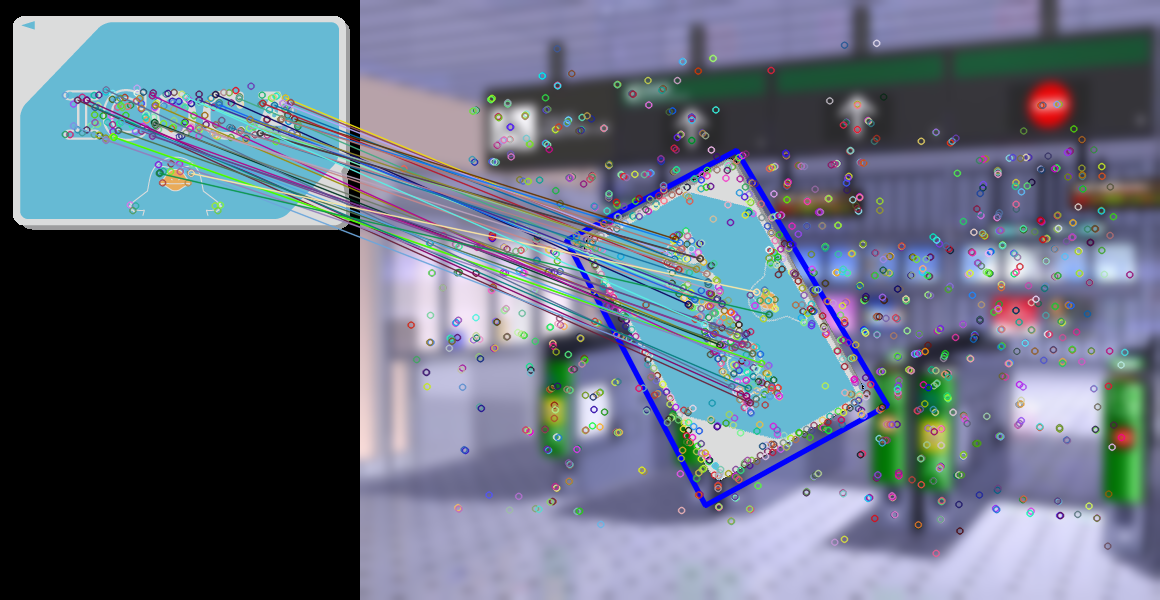

In [24]:
img = mkproblem(0)
bestmatch(img)

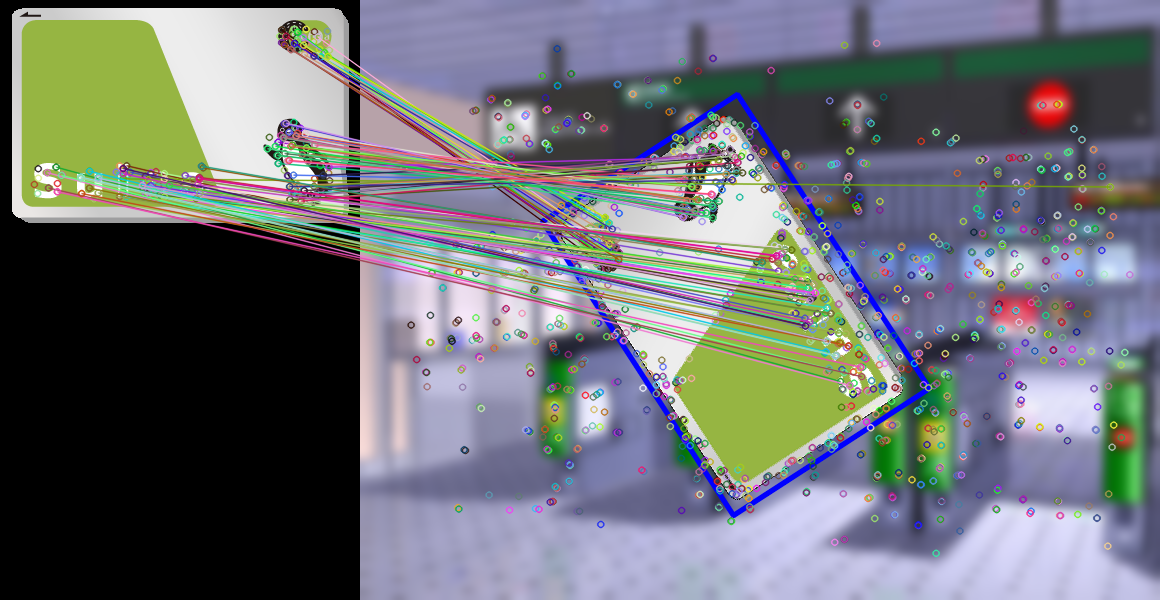

In [25]:
img = mkproblem(3)
bestmatch(img)

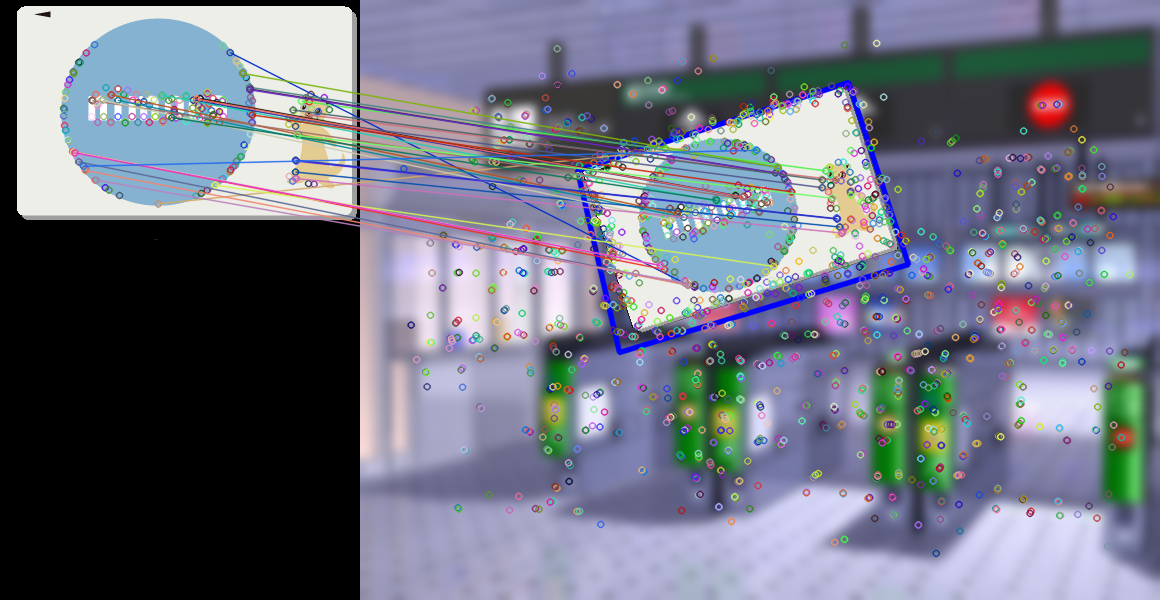

In [26]:
img = mkproblem(8)
bestmatch(img)

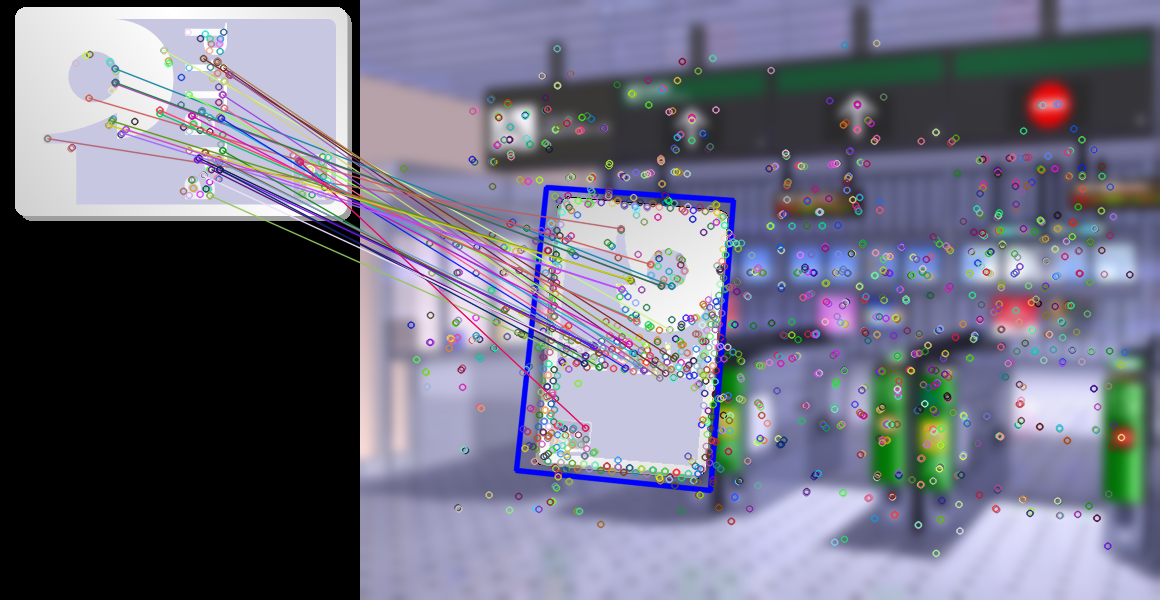

In [27]:
bestmatch(mkproblem(-1))

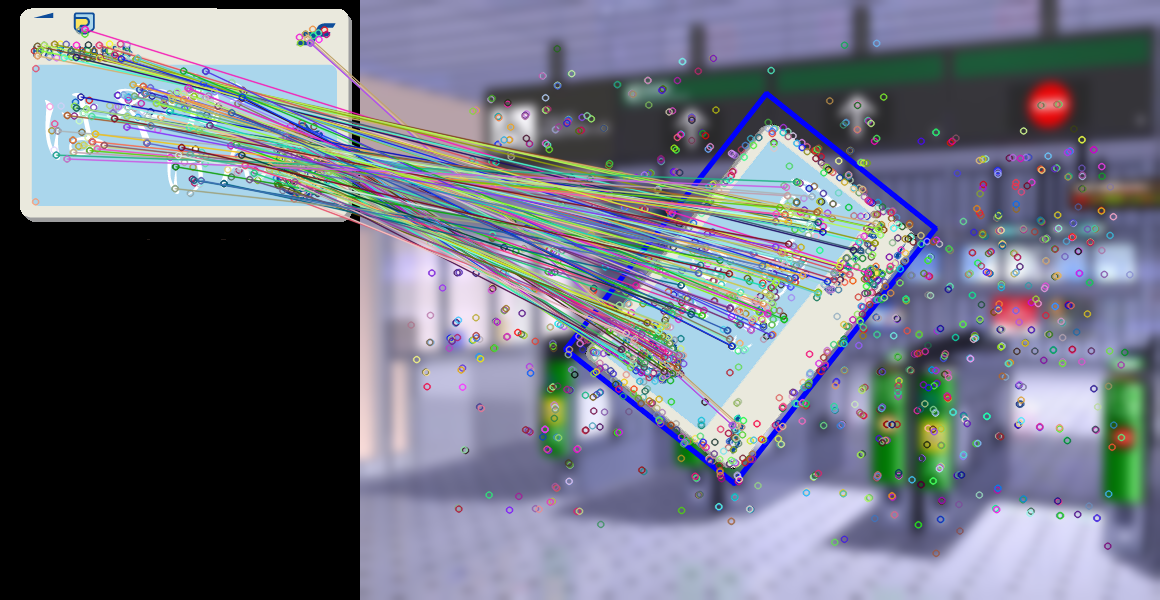

In [28]:
bestmatch(mkproblem(-1))

# 中央部に限定して探索する

動画で、リアルタイムに追跡を続けようと思うと。カメラの視野全体をサーチし続けるには、CPUパワーが要求される。

また、現実の映像では、フレーム間の変化は少なく、いきなり見えているカードが変化したりはしないので、一度カードを発見したら、次のフレームの探索範囲はもともとカードのあった領域を少しだけ広げた領域で充分であるし、マッチングすべきカードも、１つに絞ることができるので、かなり高速化できるはずである。


In [0]:
BIGNUMBER = 1e6 # 1000000 （大きい数値）

DISTANCETHRES=1024.0 # これ以上距離がある場合は候補から外す。AKAZEは61次元 で各255までで表されている

# 画像に対し、もっともマッチするものを答える
def bestmatch2(simg):
  h,w = simg.shape[:2]
  h2,w2 = h//2,w//2
  y0,x0 = h2//2,w2//2
  himg = simg[y0:y0+h2,x0:x0+w2]
  gray = cv2.cvtColor(himg,cv2.COLOR_BGR2GRAY)
  (kp2, des2) = akaze.detectAndCompute(gray,None)
  des2 = np.float32(des2)

  good = [None]*len(cardDB)
  for index,card in enumerate(cardDB):
    des1 = card.des
    des1 = np.float32(des1)
    kps1 = card.kps

    matches = flann.knnMatch(des1,des2,k=2)
    good[index] = []
    for ms in matches:
      if len(ms) ==  2: # 必ずしも第2候補まで見つかるとは限らない
        m,n = ms
        if m.distance < DISTANCETHRES and m.distance < 0.8*n.distance: # 2番目に近いものより距離が0.9未満であるマッチングを残す
          good[index].append(m)

  bestmatch,valmin,bestpairs = -1,BIGNUMBER,[] 
  for index in range(len(cardDB)):
    dd = np.sort([m.distance for m in good[index]])[:10] # 上位10個までのマッチング情報を取り出す
    if len(dd) > 0 and np.sum(dd)/len(dd) < valmin:
      bestmatch = index  
      valmin = np.sum(dd)/len(dd)

  goodbest = good[bestmatch]
  kp1 = cardDB[bestmatch].kps
  if len(goodbest) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in goodbest]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in goodbest]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0) # 変換行列
    matchesMask = mask.ravel().tolist()

    h,w = cardDB[bestmatch].gry.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(himg.copy(),[np.int32(dst)],True,255,3, cv2.LINE_AA)
    img3 = cv2.drawMatches(cardDB[bestmatch].col, kp1, img2, kp2, goodbest, None)
    cv2_imshow(img3)  

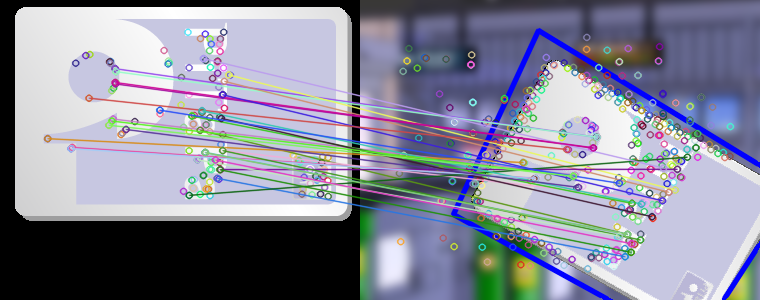

In [30]:
bestmatch2(mkproblem(-1))

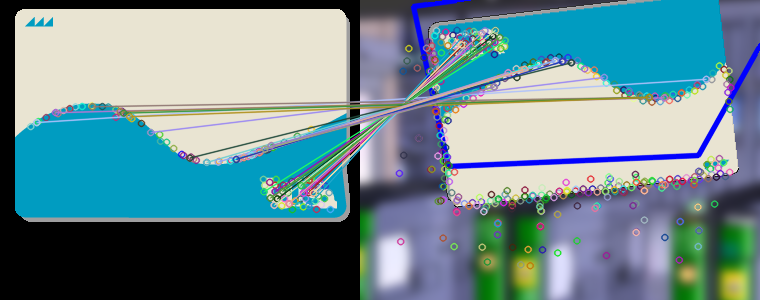

In [31]:
bestmatch2(mkproblem(-1))

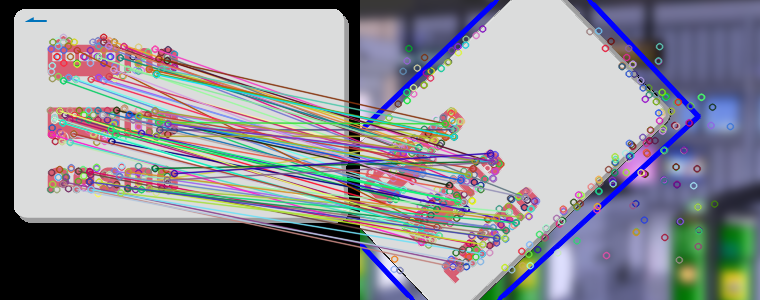

In [33]:
bestmatch2(mkproblem(-1))